In [95]:
import qutip as qt
import pandas as pd
import numpy as np

import os
import glob

from scipy.optimize import minimize_scalar


In [96]:

# list the folders in ../data
folders = glob.glob("../data/*")

folders = [f for f in folders if "1qb" in f]

# sort the folders by name
folders.sort()

folders


['../data/2025-05-16--13h-18m--2025-05-16--13h-21m_1qb_tomo_sagnac2_40mW_B_nominally_H',
 '../data/2025-05-16--13h-21m--2025-05-16--13h-24m_1qb_tomo_sagnac2_40mW_B_nominally_D',
 '../data/2025-05-16--13h-24m--2025-05-16--13h-27m_1qb_tomo_sagnac2_40mW_B_nominally_V',
 '../data/2025-05-16--13h-27m--2025-05-16--13h-30m_1qb_tomo_sagnac2_40mW_B_nominally_R',
 '../data/2025-05-16--13h-30m--2025-05-16--13h-33m_1qb_tomo_sagnac2_40mW_B_nominally_A',
 '../data/2025-05-16--13h-34m--2025-05-16--13h-36m_1qb_tomo_sagnac2_40mW_B_nominally_L',
 '../data/2025-05-16--13h-39m--2025-05-16--13h-42m_1qb_tomo_sagnac2_40mW_A_nominally_H',
 '../data/2025-05-16--13h-43m--2025-05-16--13h-45m_1qb_tomo_sagnac2_40mW_A_nominally_D',
 '../data/2025-05-16--13h-46m--2025-05-16--13h-49m_1qb_tomo_sagnac2_40mW_A_nominally_V',
 '../data/2025-05-16--13h-49m--2025-05-16--13h-52m_1qb_tomo_sagnac2_40mW_A_nominally_R',
 '../data/2025-05-16--13h-52m--2025-05-16--13h-55m_1qb_tomo_sagnac2_40mW_A_nominally_A',
 '../data/2025-05-16-

In [97]:
def extract_reconstructed_state(data, key="reconstructed_state"):

    matrix_11 = data[key][0][0]['real'] + 1j * data[key][0][0]['imag']
    matrix_12 = data[key][0][1]['real'] + 1j * data[key][0][1]['imag']
    matrix_21 = data[key][1][0]['real'] + 1j * data[key][1][0]['imag']
    matrix_22 = data[key][1][1]['real'] + 1j * data[key][1][1]['imag']

    matrix = [[matrix_11, matrix_12],
                [matrix_21, matrix_22]]
    return qt.Qobj(matrix, dims=[[2], [2]])



In [98]:
# for each folder, load the data in .../R/tomography_resutls.json and .../T/tomography_results.json

reconstructed_states = []

for folder in folders:
    last_part_of_folder = folder.split("/")[-1]

    # folder names like 2025-05-13--16h-29m--2025-05-13--16h-30m_1qb_tomo_sagnac2_40mW_B_nominally_H
    # extract the parameters from the folder name

    params = last_part_of_folder.split("_")
    nominal_state_name = params[-1]
    launcher = params[-3]
    laser_power = params[-4]

    R_file = os.path.join(folder, "R", "tomography_results.json")
    T_file = os.path.join(folder, "T", "tomography_results.json")

    if not os.path.exists(R_file) or not os.path.exists(T_file):
        print(f"Skipping {folder} because one of the files does not exist")
        continue

    R_data = pd.read_json(R_file)
    T_data = pd.read_json(T_file)

    rho_R = extract_reconstructed_state(R_data)
    rho_T = extract_reconstructed_state(T_data)
    
    target_state = extract_reconstructed_state(T_data, key="target_state")

    reconstructed_states.append({
        "folder": folder,
        "nominal_state_name": nominal_state_name,
        "launcher": launcher,
        "laser_power": laser_power,
        "reconstructed_state_T": rho_T,
        "reconstructed_state_R": rho_R,
        "target_state": target_state
    })

reconstructed_states[-1]['reconstructed_state_T']



Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0.53868501+0.j        0.13266321-0.4753501j]
 [0.13266321+0.4753501j 0.46131499+0.j       ]]

In [99]:
def density_to_bloch_coords(rho):
    x = np.real((rho * qt.Qobj([[0, 1], [1, 0]])).tr())  # ⟨σx⟩
    y = np.real((rho * qt.Qobj([[0, -1j], [1j, 0]])).tr())  # ⟨σy⟩
    z = np.real((rho * qt.Qobj([[1, 0], [0, -1]])).tr())  # ⟨σz⟩
    return [x, y, z]


bloch = density_to_bloch_coords(reconstructed_states[0]['reconstructed_state_T'])
bloch

[-0.005452393987172, -0.027208885261254003, 0.9849872891506111]

In [100]:
# add the bloch coordinates to the reconstructed states
for state in reconstructed_states:
    bloch_coords_T = density_to_bloch_coords(state['reconstructed_state_T'])
    state['bloch_coords_T'] = bloch_coords_T
    bloch_coords_R = density_to_bloch_coords(state['reconstructed_state_R'])
    state['bloch_coords_R'] = bloch_coords_R

reconstructed_states[0]['bloch_coords_T']

[-0.005452393987172, -0.027208885261254003, 0.9849872891506111]

In [101]:
# D
reconstructed_states[2]['bloch_coords_T']

[0.04557242319403201, 0.057818242563296006, -0.987566300878517]

In [102]:
# A
reconstructed_states[4]['bloch_coords_T']

[0.9681075665429301, 0.21375003841696602, 0.03896624610737204]

In [103]:
# L
reconstructed_states[5]['bloch_coords_T']

[-0.17735187723679602, 0.9639187706794321, 0.008559422176182996]

In [104]:
# R
reconstructed_states[3]['bloch_coords_T']

[0.219886624768854, -0.9632740707095361, -0.005820974095072984]

H


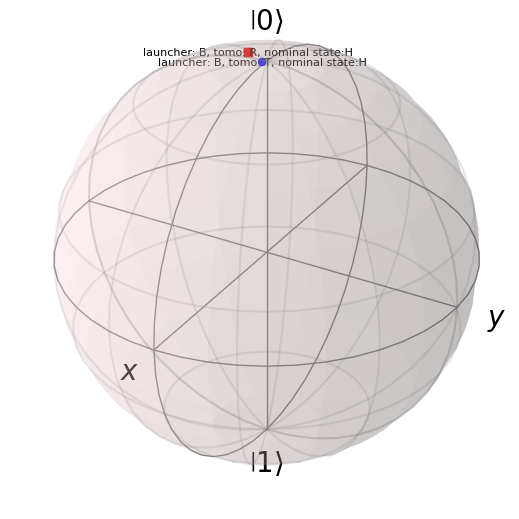

D


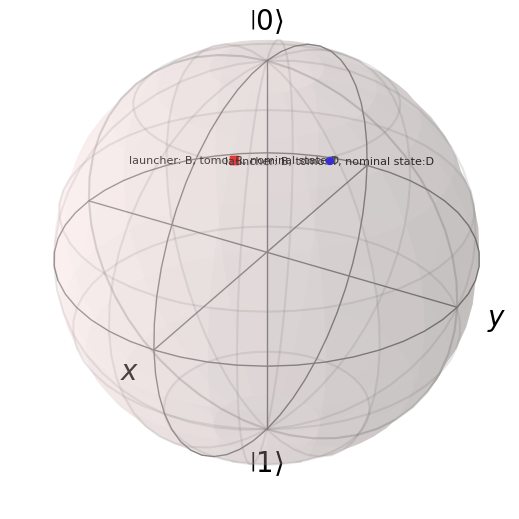

V


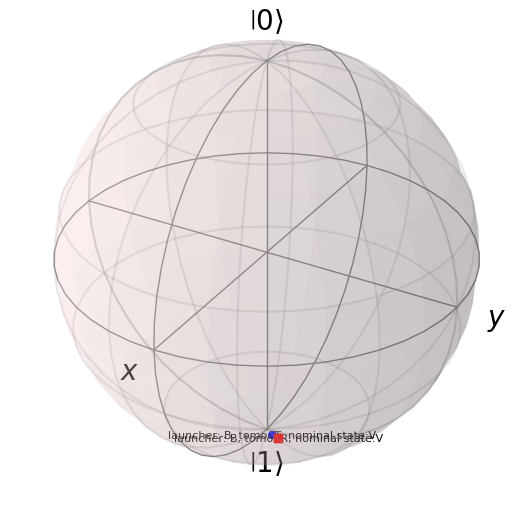

R


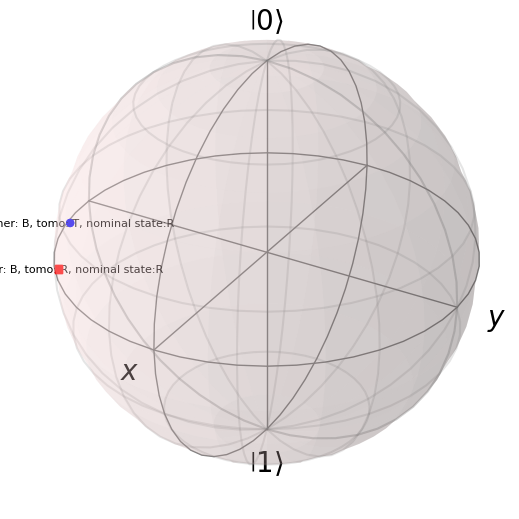

A


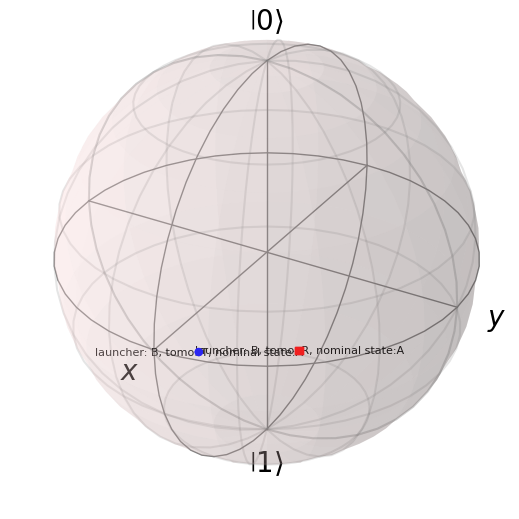

L


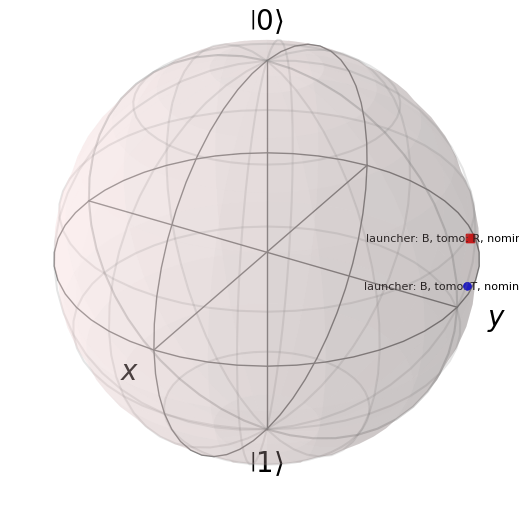

H


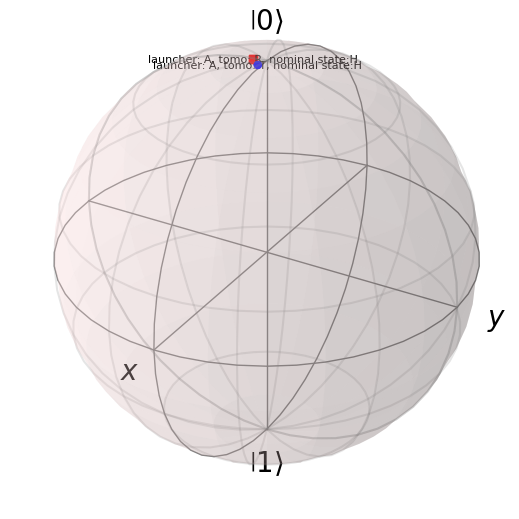

D


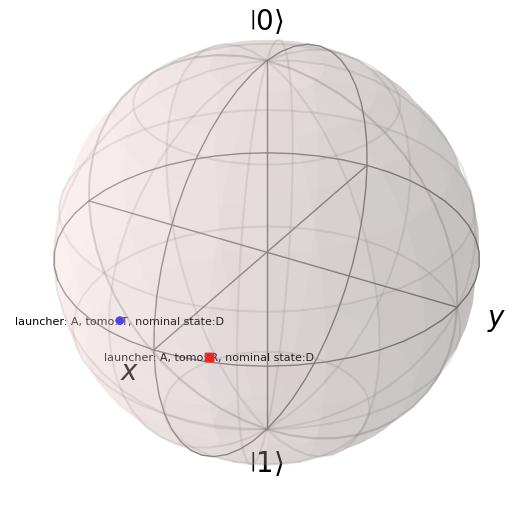

V


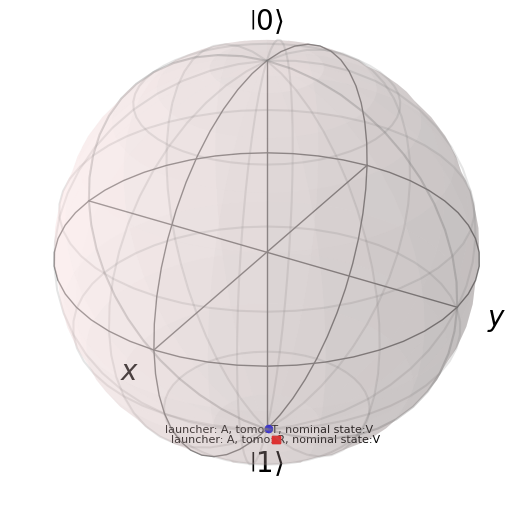

R


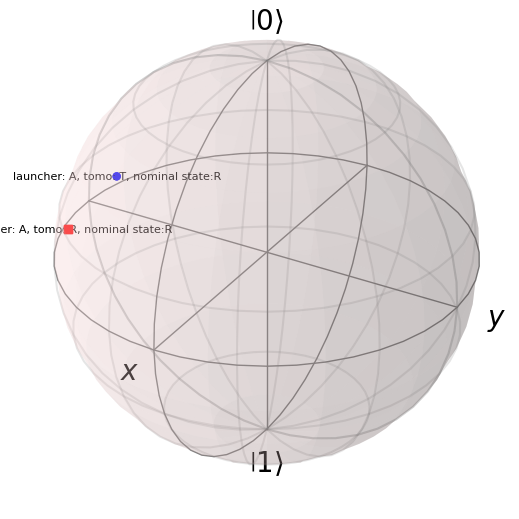

A


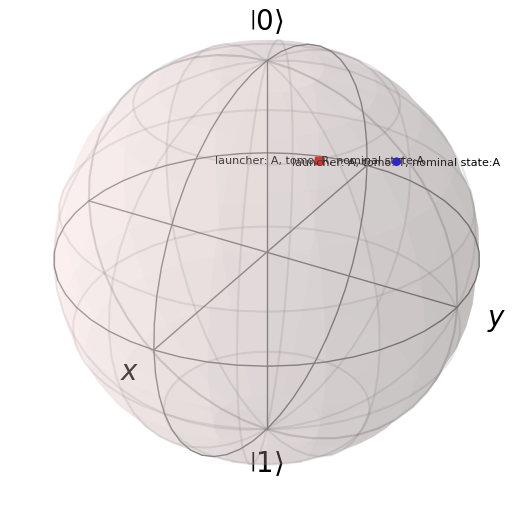

L


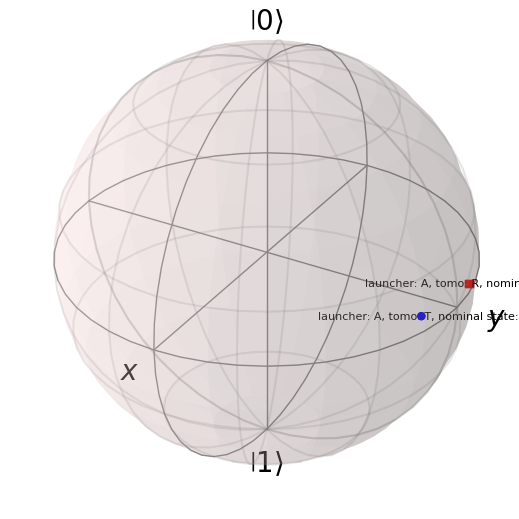

In [105]:
# b = qt.Bloch()
# bloch_coords_T = state['bloch_coords_T']
# b.add_points(bloch_coords_T)

# b.add_annotation(bloch_coords_T, state['launcher'] + "T")

# bloch_coords_R = state['bloch_coords_R']
# b.add_points(bloch_coords_R)

# b.add_annotation(bloch_coords_R, state['launcher'] + "R")

# Add points
for state in reconstructed_states:
    # new bloch sphere for each state
    b = qt.Bloch()
    # make the image bigger
    b.make_sphere()
    bloch_coords_T = state['bloch_coords_T']
    b.add_points(bloch_coords_T)
    print(state["nominal_state_name"])
    b.add_annotation(bloch_coords_T, "launcher: " + state['launcher'] + ", tomo: T, nominal state:" + state['nominal_state_name'], fontsize=8)
    bloch_coords_R = state['bloch_coords_R']
    b.add_points(bloch_coords_R)
    b.add_annotation(bloch_coords_R, "launcher: " + state['launcher'] + ", tomo: R, nominal state:" + state['nominal_state_name'], fontsize=8)

    # Display
    b.show()

In [106]:
# for each of the launcher B states, find the phase angle of the state in the T tomography
def phase_angle(state):
    if state['launcher'] == "B":
        bloch_coords = state['bloch_coords_T']
    elif state['launcher'] == "A":
        bloch_coords = state['bloch_coords_R']
    else:
        raise ValueError("Launcher must be either A or B")
    # get the x and y coordinates
    x = bloch_coords[0]
    y = bloch_coords[1]
    # calculate the angle
    angle = np.arctan2(y, x)
    return angle

# get the phase angle for each state
phase_angles = []
for state in reconstructed_states:
    angle = phase_angle(state)
    phase_angles.append({
        "folder": state['folder'],
        "nominal_state_name": state['nominal_state_name'],
        "launcher": state['launcher'],
        "laser_power": state['laser_power'],
        "phase_angle": angle
    })

# convert to dataframe
phase_angles_df = pd.DataFrame(phase_angles)

# add the phase angle in degrees
phase_angles_df['phase_angle_degrees'] = phase_angles_df['phase_angle'] * 180 / np.pi % 360

# add the intended phase angle based on the nominal state name
def intended_phase_angle(nominal_state_name):
    if nominal_state_name == "D":
        return 0
    elif nominal_state_name == "R":
        return 90
    elif nominal_state_name == "A":
        return 180
    elif nominal_state_name == "L":
        return 270

phase_angles_df['intended_phase_angle'] = phase_angles_df['nominal_state_name'].apply(intended_phase_angle)

# add the phase angle difference
phase_angles_df['phase_angle_difference'] = (phase_angles_df['phase_angle_degrees'] - phase_angles_df['intended_phase_angle']) % 360


phase_angles_df

,folder,nominal_state_name,launcher,laser_power,phase_angle,phase_angle_degrees,intended_phase_angle,phase_angle_difference
0,../data/2025-05-16--13h-18m--2025-05-16--13h-2...,H,B,40mW,-1.768567,258.668572,NaN,NaN
1,../data/2025-05-16--13h-21m--2025-05-16--13h-2...,D,B,40mW,-2.945829,191.216432,0.0,191.216432
2,../data/2025-05-16--13h-24m--2025-05-16--13h-2...,V,B,40mW,0.903291,51.754770,NaN,NaN
3,../data/2025-05-16--13h-27m--2025-05-16--13h-3...,R,B,40mW,-1.346372,282.858590,90.0,192.858590
4,../data/2025-05-16--13h-30m--2025-05-16--13h-3...,A,B,40mW,0.217305,12.450674,180.0,192.450674
5,../data/2025-05-16--13h-34m--2025-05-16--13h-3...,L,B,40mW,1.752752,100.425281,270.0,190.425281
6,../data/2025-05-16--13h-39m--2025-05-16--13h-4...,H,A,40mW,-1.677367,263.893978,NaN,NaN
7,../data/2025-05-16--13h-43m--2025-05-16--13h-4...,D,A,40mW,0.264635,15.162479,0.0,15.162479
8,../data/2025-05-16--13h-46m--2025-05-16--13h-4...,V,A,40mW,0.899735,51.551017,NaN,NaN
9,../data/2025-05-16--13h-49m--2025-05-16--13h-5...,R,A,40mW,-1.294828,285.811807,90.0,195.811807
